In [1]:
%load_ext autoreload

%autoreload 2


In [2]:
def get_bval(G, TE, dt):
    if (G.squeeze().ndim == 4):
        G = G[0]  # TODO: 3-axis case, right now just assumes 1 axis
        
    tINV = int(np.floor(TE/dt/2.0))
    GAMMA   = 42.58e3; 
    
    INV = np.ones(G.size)
    INV[tINV:] = -1
    Gt = 0
    bval = 0
    for i in range(G.size):
        if i < tINV:
            Gt += G[i] * dt
        else:
            Gt -= G[i] * dt
        bval += Gt*Gt*dt

    bval *= (GAMMA*2*np.pi)**2
    
    return bval


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import pypulseq as pp
sys.path.append('Sequence/')
from pSeq_Base import pSeq_Base
from pSeq_RF import pSeq_RF
from pSeq_EPI_base import pSeq_EPI_base
from pSeq_FatSat import pSeq_FatSat

from pSeq_GrOpt import pSeq_GrOpt

In [5]:
import os
print(pp.__file__)
plt.rcdefaults()



/Users/ariel/Documents/GitHub/pypulseq/pypulseq/__init__.py


In [6]:
# Interleaved offset factor 
def get_freq_offest(Nslices, thickness = 3e-3, slice_gap = 0):
    # Calculate slice positions
    slicePositions = (thickness + slice_gap) * (np.arange(Nslices) - (Nslices - 1) / 2)

    # Reorder slices for an interleaved acquisition
    slicePositions = np.concatenate((slicePositions[0:Nslices:2], slicePositions[1:Nslices:2]))
    return slicePositions


In [7]:
# Variables to Customize

gmax = 200
smax = 200

gmax_epi = gmax


duration = 3e-3
fov =220e-3 #220
real_fov = 220e-3#150e-3
nx = 146 #110 # or 110
ny = 146 #110 # or 110

pf = 0.75
R = 2

    
if nx == 146 and R==2:
    gmax_epi = 180 #34 #40      #38 # 32 for high, 38 for low
    #readoutTime =6.7e-4 #8.9e-4     #6.8e-4 #8.9e-4 #7 for high , 8.9 for low
    #smax_epi = 115           #130 # 130 for high, 130 for low 
    readoutTime =6.4e-4     #6.8e-4 #8.9e-4 #7 for high , 8.9 for low
    smax_epi = 120#130           #130 # 130 for high, 130 for low 
    thickness  = 1.5e-3
    slice_gap = thickness*3


Nslices = 1
reduced_fov = False
partoforiginalFOV = real_fov #200e-3 #; %rewrite this to be a percentage of FOV ? for now in mm
ssgr_mode = True

ro_os = 1

diff_mode = 'Trap' #"Trap" # or GrOpt or None 
mmt = 0
averages = 1

if diff_mode == 'GrOpt':
    if mmt == 0:
        pns_thresh = 0.9
        gmax_diff = 200
    if mmt == 1:
        pns_thresh = 0.9
        gmax_diff = 190
        

if diff_mode == 'Trap':
    if mmt == 0:
        pns_thresh = 10
        gmax_diff = 200
    
    if mmt == 1:
        pns_thresh = 0.9
        gmax_diff = 190

Rsegment = 1
if Rsegment > 1:
    EchoTimeShift = 1
else:
    EchoTimeShift = 0


ecg = True
seq_type = None


inner_volume = False
iv_thickness = 150e-3

if real_fov == 150e-3:
    smax_epi = 120
    readoutTime = 6.5e-4

seq_file_name = 'fig_cima_workshop' + str(nx) + 'x' + str(ny) + '_R' + str(R) + '_pf' + str(pf) 
fatSat_band = False
freq_offset = False


tbw_180 = 4
dur_90= 3e-3
dur_180 = 3e-3
ftype = 'min'
ftype_90 = 'min'

pulse_type = 'sinc'


fat_sat_type ='FatSat3'#'None'#'SPAIR'#ommrt'SPAIR'##'SPAIR' #None#'SPAIR'#'None'#'FatSat' #STIR' #'FatSat' # FatSat STIR, SPAIR, SPIR 
fsdelay = 0e-3
fat_dur = 3e-3

print('Slice Gap = ',slice_gap)
if seq_type == "Skope":
    seq_file_name += "_Skope"

if reduced_fov:
    seq_file_name += '_reducedFOV_' + str(int(partoforiginalFOV*1e3)) + 'mm'

if inner_volume:
    seq_file_name += "_iv_"

if ssgr_mode:
    seq_file_name += "ssgr_"

if freq_offset:
    seq_file_name += 'freqOffset_'



freqOffset_factor = get_freq_offest(Nslices,slice_gap = slice_gap, thickness=thickness)


seq_file_name += "_" + pulse_type


include_noise = False
if R>1 and  include_noise:
    seq_file_name += '_noise_'

# Name seq file

seq_file_name += '_R' + str(R) + '_NSl'+ str(int(Nslices)) + 'Avg' + str(averages)+'_PF' + str(pf) +'_'+\
    '_FOV' + str(int(real_fov*1e3)) 
     
#if pulse_type == 'SLR':
#    seq_file_name+= ftype

if fatSat_band:
    seq_file_name+= '_satBand'


if diff_mode is not None:
    seq_file_name+= '_' + diff_mode
    
#flip_gy = False
#if flip_gy:
#    seq_file_name += '_flipGY' 

#slice_profile = False
#if slice_profile:
#    seq_file_name += '_sliceProfile' 



bval = 1000


seq_file_name += '_mmt' + str(mmt) 
seq_file_name += '_b' + str(bval) 

print(seq_file_name)
print(freqOffset_factor)

Slice Gap =  0.0045000000000000005
fig_cima_workshop146x146_R2_pf0.75ssgr__sinc_R2_NSl1Avg1_PF0.75__FOV220_Trap_mmt0_b1000
[0.]


In [ ]:
# Example diffusion directions 
all_diff_vec = [[1,0,0],[0,1,0],[0,0,1]] 



In [10]:
# Initialize Baseline Sequence object 
pseq0 = pSeq_Base(channels = ('x','y','z'), max_grad = gmax, max_slew = smax, rf_ringdown_time = 10e-6, rf_dead_time= 100e-6, b0= 2.89)
pseq0.init_epi_system(channels = ('x','y','z'), max_grad = gmax_epi, max_slew = smax_epi, rf_ringdown_time = 10e-6, rf_dead_time= 100e-6, b0= 2.89)


# Initialize FatSat and Spoilers
if fat_sat_type is not None:
   pseq_fatsat = pSeq_FatSat(slice_thickness=thickness,type = fat_sat_type,duration = fat_dur, system = pseq0.system)
   pseq_fatsat.prep_fatsat()
   pseq_fatsat.prep_spoiler()


# Initialize Saturation bands
if fatSat_band:
   sat_freqOffset_factor = get_freq_offest(3,slice_gap = 0e-3, thickness=100e-3)
   print('Saturation Offsets',sat_freqOffset_factor[0], sat_freqOffset_factor[1],    )

   pseq_fatSat_B1 = pSeq_RF(pseq0, flip_angle = np.pi/2,use = "saturation",do_refocus = False,duration=dur_90, thickness = 100e-3,system = pseq0.seq.system)
   pseq_fatSat_B1.prep(tbw=4,apodization=0.5, verbose = True, default = 'sinc', SLR_params = None,ftype = 'ms',inner_volume = False)
   pseq_fatSat_B1.offset_rf(offset= sat_freqOffset_factor[0])

   pseq_fatSat_B2 = pSeq_RF(pseq0, flip_angle = np.pi/2,use = "saturation",do_refocus = False,duration=dur_90, thickness = 100e-3,system = pseq0.seq.system)
   pseq_fatSat_B2.prep(tbw=4,apodization=0.5, verbose = True, default = 'sinc', SLR_params = None,ftype = 'ms',inner_volume = False)
   pseq_fatSat_B2.offset_rf(offset= sat_freqOffset_factor[1])


# Initialize 90 degree pulse
if not inner_volume or reduced_fov:
   print('Not inner volume or reduced FOV add buffer thickness')
   thickness_90 = thickness + 0.5e-3
else:
   thickness_90 = thickness
pseq_90 = pSeq_RF(pseq0, flip_angle = np.pi/2,use = "excitation",do_refocus = True,duration=dur_90, thickness = thickness_90)
pseq_90.prep(apodization = 0.5, tbw=4, default = pulse_type,ftype = ftype_90)
pseq_90.get_timing()
pseq_90.prep_trig(seq_type = seq_type)


# If Inner volume offset 180 
if inner_volume: 
   pseq_180 = pSeq_RF(pseq0, flip_angle = np.pi,use = "refocusing",do_refocus = False,duration = dur_180, thickness = iv_thickness,
                  apodization = 0.5, tbw=tbw_180, phase_offset = np.pi/2, type = pulse_type)
   pseq_180.prep(tbw= tbw_180,ftype = ftype,default = pulse_type)

else: 
   pseq_180 = pSeq_RF(pseq0, flip_angle = np.pi,use = "refocusing",do_refocus = False,duration = dur_180, thickness = thickness,
                  apodization = 0.5, tbw=tbw_180, phase_offset = np.pi/2, type = pulse_type)
   pseq_180.prep(tbw= tbw_180,ftype = ftype,default = pulse_type)

# If reduced fov offset 180 
if reduced_fov:
   pseq_90.gzReph.area= 0

   #  [grad, times, amplitudes] = makeExtendedTrapezoidArea(channel, Gs, Ge, A, sys)
   [__, gzr_t, gzr_a]=pp.make_extended_trapezoid_area(channel = 'z',grad_start = pseq_180.gz.amplitude,grad_end = 0,area = -pseq_90.gzReph.area+0.5*pseq_180.gz.amplitude*pseq_180.gz.fall_time,system = pseq0.seq.system)

   times = np.concatenate(([0, pseq_180.gz.rise_time], pseq_180.gz.rise_time+pseq_180.gz.rise_time+gzr_t)) + pseq_180.gz.delay
   amplitudes = np.concatenate(([0,pseq_180.gz.amplitude],gzr_a))
   amplitudes = np.array([0, 1.6667e+05, 1.6667e+05, 0])
   times = np.array([80/1e6, 100/1e6,3.1e3/1e6, 3.12e3/1e6])
   gz180n=pp.make_extended_trapezoid(channel = 'z',system = pseq0.seq.system,times =  times, amplitudes = amplitudes)
   print(gz180n)
   gz180n.amplitude = np.max(amplitudes)
   pseq_180.gz = gz180n

   dummy_90 = pSeq_RF(pseq0, flip_angle = np.pi/2,use = "excitation",do_refocus = True,duration=dur_90, thickness = partoforiginalFOV)
   dummy_90.prep(apodization = 0.5, tbw=4, default = pulse_type,ftype = ftype_90)
   dummy_90.gzReph.channel = 'y'
   dummy_90.gz.channel = 'y'
   
   pseq_90.gz = dummy_90.gz
   pseq_90.gzReph = dummy_90.gzReph


   #[~, gzr_t, gzr_a]=mr.makeExtendedTrapezoidArea('z',gz180.amplitude,0,-gzReph.area+0.5*gz180.amplitude*gz180.fallTime,lims);
   # gz180n=mr.makeExtendedTrapezoid('z','system',lims,'times',[0 gz180.riseTime gz180.riseTime+gz180.flatTime+gzr_t]+gz180.delay, 'amplitudes', [0 gz180.amplitude gzr_a]);

   

# Initialize EPI Sequence to get readout duration 
pseq_epi = pSeq_EPI_base(pseq0,fov = real_fov,
                nx = nx,
                ny = ny,
                readoutTime = readoutTime,
                Rsegment = Rsegment,
                partFourierFactor = pf,
                R=R,
                Nmulti=1,
                ghost_lines = 3,)

pseq_epi.prep(ro_os = ro_os)
pseq_epi.get_timeToTE()

rf_90dict = pseq_90.get_timing()[1]
   
# Initialize Diffusion Waveform      
pseq_diff = pSeq_GrOpt(pseq0,pns_thresh = pns_thresh,
                    t_90 = rf_90dict['timing']*1e3, 
                    rf_90dict = rf_90dict,
                    t_180 = (pseq_180.get_timing()[0]) *1e3,
                    rf_180dict = pseq_180.get_timing()[1],
                    T_readout = pseq_epi.get_timeToTE()['timeToTE']*1e3,
                    pre_duration = pseq_epi.get_timeToTE()['pre_duration']*1e3,
                    durationToCenter= pseq_epi.get_timeToTE()['durationToCenter']*1e3,
                    gmax = gmax_diff,
                    smax = 187,
                    dt = 1e-5,
                    mmt =mmt,
                    b = bval,
                    
                    )                     

pseq_diff.prep_crusher()
pseq_diff.get_min_delay()
print('Min Delay',pseq_diff.min_delayTE1, pseq_diff.min_delayTE2)
pseq_diff.timings                  
pseq_diff.get_min_delay()

pseq_diff.timings #, pseq_fatsat.rf_fs, pseq_fatsat.gz_fs

-424.504008
0.003 0.0015
Make Fat Sat Debugging! 
Sat Frequency is -406.04731200000003
Not inner volume or reduced FOV add buffer thickness
Making Sinc Pulse with flip angle 1.5707963267948966
excitation : The peak rf Amplitude =  7.730195187639467 uT
Making Sinc Pulse with flip angle 3.141592653589793
refocusing : The peak rf Amplitude =  15.460390375278934 uT
EPI: Echo Spacing is  0.7400000000000001 ms
EPI: ADC Bandwidth =  416.6666666666667 kHz
Actual RO oversampling factor is   1.0366530914476122
EPI: ADC Samples are  264.0
crusher max slew 8515200000
Min Delay 0.01288 0.0009500000000000001


{'T_90': np.float64(2.28),
 'T_180': 5.119999999999999,
 'dt': 1e-05,
 'T_readout': np.float64(14.210000000000003),
 'durationToCenter': np.float64(13.690000000000003),
 'pre_duration': 0.52,
 'b': 1000,
 'MMT': 0,
 'pns_thresh': 10,
 'gmax': 199,
 'smax': 186,
 'tol': 0.01,
 'mode': 'diff_bval'}

In [11]:
pseq_diff.gz180_crusher_1,pseq_diff.gz180_crusher_2,pseq_diff.gz180_crusher_3

(namespace(type='trap',
           channel='z',
           amplitude=811149.0,
           rise_time=0.0001,
           flat_time=0.0007499999999999999,
           fall_time=0.0001,
           area=689.47665,
           flat_area=608.3617499999999,
           delay=0,
           first=0,
           last=0),
 namespace(type='trap',
           channel='y',
           amplitude=811149.0,
           rise_time=0.0001,
           flat_time=0.0007499999999999999,
           fall_time=0.0001,
           area=689.47665,
           flat_area=608.3617499999999,
           delay=0,
           first=0,
           last=0),
 namespace(type='trap',
           channel='x',
           amplitude=811149.0,
           rise_time=0.0001,
           flat_time=0.0007499999999999999,
           fall_time=0.0001,
           area=689.47665,
           flat_area=608.3617499999999,
           delay=0,
           first=0,
           last=0))

Gmax 200 and Smax 200
PNS: 2.57, B-val: 988.82, TE = 44.26, Smax = 200.00,Gmax = 200.00
0.014961238938053095
-3.699376992679647e-17
-1.0
-1.0
-1.0
44.260000000000026


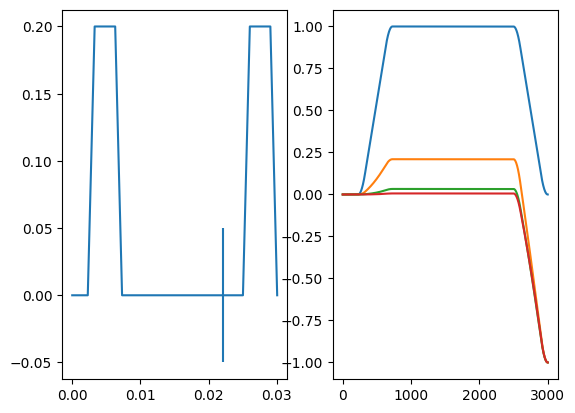

In [12]:

if diff_mode == 'Trap':
    if mmt == 1:
        gmax_custom = 120
        smax_custom = 60
    if mmt == 0:
        gmax_custom = 200
        smax_custom = 200
    pseq_diff.make_trap(smax_custom = smax_custom, gmax_custom = gmax_custom )
    
    pseq_diff.trap_params
    plt.subplot(121)
    plt.plot(pseq_diff.trap_params['Time'],pseq_diff.trap_params['Gradient'])
    plt.vlines(pseq_diff.trap_params['TE']/2*1e-3,ymin = -0.05,ymax = 0.05)
    plt.subplot(122)
    moments = pseq_diff.get_moments1(pseq_diff.trap_params['Gradient'],pseq_diff.timings['T_readout'],pseq_diff.timings['dt'])
    pseq_diff.prep_trap()
    pseq_diff.get_delay()
    pseq_diff.delayTE1,pseq_diff.delayTE2- pp.calc_duration(pseq_diff.trapA)*2, pseq_diff.gap

    for mm in moments:
        plt.plot(mm)
        print(mm[-1])
    print(pseq_diff.trap_params['TE'])

if diff_mode == 'GrOpt':
    pseq_diff.make_gropt()
    pseq_diff.split_gropt()


In [13]:
plt.rcdefaults()
pseq_diff.get_delay()
pseq_diff.delayTE1, pseq_diff.delayTE2



(np.float64(0.018260000000000002), np.float64(0.0063300000000000006))

In [14]:
pseq_180.get_timing()

(0.0032199999999999998,
 {'timing': 0.0032199999999999998, 'center_incl_delay': np.float64(0.00161)})

# Calibration

In [15]:
# Iterate Over Diffusion Vectors 
import copy
count = 0
if R > 1:
    if include_noise:
    
        noise_grad= copy.deepcopy(pseq_epi.gx)
        noise_grad = pp.scale_grad(noise_grad,0)
        pseq0.seq.add_block(pseq_epi.adc,noise_grad)
        [k_traj_adc, k_traj,t_excitation, t_refocusing, t_adc]  = pseq0.seq.calculate_kspace()
        plt.plot(k_traj_adc[0,:], k_traj_adc[1,:],'r.')
        plt.title('k-space trajectory (k_x/k_y)'+str(k_traj_adc.shape))
        print(k_traj_adc.shape)
        plt.show()
    
    for dd in [[0,0,0],[0,0,0]]:
        # Iterate over slices 
        #pseq0.seq.add_block(pp.make_label(type= 'SET', label='SLC', value=0) )
        for s in range(Nslices):
            # Set up the Diffusi/on Vector
            #pseq_diff.prep_trap(diff_vec = dd)
            #pseq_diff.prep_GrOpt(diff_vec = dd)

            # Set up the EPI readout
            for Nmulti in range(1,Rsegment+1):
                if seq_type == 'Skope':
                    pseq_fatsat.rf_fs.signal *= 0
                    pseq_90.rf.signal *= 0
                    pseq_180.rf.signal *= 0
                
                # PE Enable is off for first one for ghost scan
                if count == 0:
                    pe_enable = False
                else:
                    pe_enable = True

                # EPI Prep needs to b/e done slice by slice and if two shots 
                pseq_epi = pSeq_EPI_base(pseq0, fov = real_fov,
                                nx = nx,
                                ny = ny,
                                readoutTime = readoutTime,
                                Rsegment = Rsegment,
                                partFourierFactor = pf,
                                R=R,
                                Nmulti=Nmulti,
                                ghost_lines = 3)
    
                pseq_epi.prep(ro_os = ro_os,pe_enable = pe_enable)


                pseq_epi.prep_calib(pe_enable = pe_enable)
                pseq_epi.get_timeToTE(save= False)
                


                # Add Trig
                if ecg:
                    pseq0.add_ecgTrig(duration = 1e-3)


                # Add FatSat 
                if seq_type != 'Skope' and fat_sat_type is not None:
                    pseq_fatsat.prep_fatsat(verbose = True, freq_offset = freqOffset_factor[s])
                    pseq0.add_pseq_to_self(pseq_fatsat,delay = fsdelay,offset =freqOffset_factor[s])
                
                if fatSat_band:
                    pseq0.add_pseq_to_self(pseq_fatSat_B1)
                    pseq0.add_pseq_to_self(pseq_fatSat_B2)

                # Add Excitation
                pseq_90.offset_rf(offset= freqOffset_factor[s])
                pseq0.add_pseq_to_self(pseq_90)
                #rf90_phase_offset.append(pseq_90.rf.phase_offset)
                #rf90_freq_offset.append(pseq_90.rf.freq_offset)
                

                # Add Diffusion
                if not diff_mode:
                    pseq0.seq.add_block(pp.make_delay(pseq_diff.min_delayTE1))
                elif diff_mode == 'Trap':
                    pseq_diff.prep_trap(diff_vec = dd)
                    pseq_diff.add_to_seq(pseq0,flag = 'diff1',diff_mode = diff_mode)
                elif diff_mode == 'GrOpt':
                    pseq_diff.prep_GrOpt(diff_vec = dd)
                    pseq_diff.add_to_seq(pseq0,flag = 'diff1',diff_mode = diff_mode)
                    
                #pseq0.add_pseq_to_self(pseq_diff,flag = "diff1")
                pseq0.seq.add_block(pseq_diff.gz180_crusher_1, pseq_diff.gz180_crusher_2,pseq_diff.gz180_crusher_3)


                # Add Refocusing 
                pseq_180.offset_rf(offset= freqOffset_factor[s])

                if ssgr_mode:
                    pseq_180.gz = pp.scale_grad(pseq_180.gz,-1)
                    pseq_180.rf.freq_offset *= -1 
                    pseq_180.phase_offset = - 2*np.pi * pseq_180.rf.freq_offset * pp.calc_rf_center(pseq_180.rf)[0]
                

                
                if inner_volume:
                    pseq_180.gz.channel = 'y'

                
                pseq0.add_pseq_to_self(pseq_180)

                #rf180_phase_offset.append(pseq_180.rf.phase_offset)
                #rf180_freq_offset.append(pseq_180.rf.freq_offset)


                # Add Diffusion or Delay + Bipolar 
                #pseq0.add_pseq_to_self(pseq_diff,flag = "diff2")
                
                pseq0.seq.add_block(pseq_diff.gz180_crusher_1, pseq_diff.gz180_crusher_2,pseq_diff.gz180_crusher_3)
                #pseq0.add_pseq_to_self(pseq_diff,flag = "diff2")

                if not diff_mode:
                    pseq0.seq.add_block(pp.make_delay(pseq_diff.min_delayTE2))
                elif diff_mode == 'Trap':
                    pseq_diff.prep_trap(diff_vec = dd)
                    pseq_diff.add_to_seq(pseq0,flag = 'diff2',diff_mode = diff_mode)

                elif diff_mode == 'GrOpt':
                    pseq_diff.prep_GrOpt(diff_vec = dd)
                    pseq_diff.add_to_seq(pseq0,flag = 'diff2',diff_mode = diff_mode)
                
                
                # Add EPI 
                pseq_epi.ghost_flag = False
                pseq0.add_pseq_to_self(pseq_epi, EchoTimeShift=EchoTimeShift,calib= True)

                #pseq0.seq.add_block(pp.make_label(type = 'INC',label = 'SLC', value = 1))
                
                # TR Calculation
                fatsat_dur = pp.calc_duration(pseq_fatsat.gx_crush_pre,pseq_fatsat.gy_crush_pre,pseq_fatsat.gz_crush_pre) \
                    + pp.calc_duration(pseq_fatsat.rf_fs) + pp.calc_duration(pseq_fatsat.gx_crush_post,pseq_fatsat.gy_crush_post,pseq_fatsat.gz_crush_post)
                
                TR = 260e-3 - fatsat_dur - pseq_diff.timings['T_90']*1e-3 - pseq_diff.delayTE1 - \
                    pseq_diff.timings['T_180']*1e-3 - pseq_diff.delayTE2 - \
                        2*pseq_diff.timings['durationToCenter']*1e-3 + pseq_diff.timings['pre_duration']*1e-3
                print('TR pad is', TR)
                pseq0.add_TR(TR=TR)
                print(count,pe_enable,pseq_epi.calib_gy_blipup.waveform)
            


        count += 1 

    pseq0.get_report()
    #rep = pseq0.seq.test_report()

        



        
        

EPI: Echo Spacing is  0.7400000000000001 ms
EPI: ADC Bandwidth =  416.6666666666667 kHz
Actual RO oversampling factor is   1.0366530914476122
EPI: ADC Samples are  264.0
Time to TE is 0.014210000000000002
Make Fat Sat Debugging! 
Sat Frequency is -406.04731200000003
0.014961238938053095
0.014961238938053095
TR pad is 0.18892
0 False [ 0. -0. -0.]
EPI: Echo Spacing is  0.7400000000000001 ms
EPI: ADC Bandwidth =  416.6666666666667 kHz
Actual RO oversampling factor is   1.0366530914476122
EPI: ADC Samples are  264.0
Time to TE is 0.014210000000000002
Make Fat Sat Debugging! 
Sat Frequency is -406.04731200000003
0.014961238938053095
0.014961238938053095
TR pad is 0.18892
1 True [     0.         -64935.06493506 -64935.06493506]
Timing check passed successfully


# In Vivo

[1, 0, 0]
EPI: Echo Spacing is  0.7400000000000001 ms
EPI: ADC Bandwidth =  416.6666666666667 kHz
Actual RO oversampling factor is   1.0366530914476122
EPI: ADC Samples are  264.0
Make Fat Sat Debugging! 
Sat Frequency is -406.04731200000003
0.014961238938053095
0.014961238938053095
gyPre 1.0 gxPre -1.0


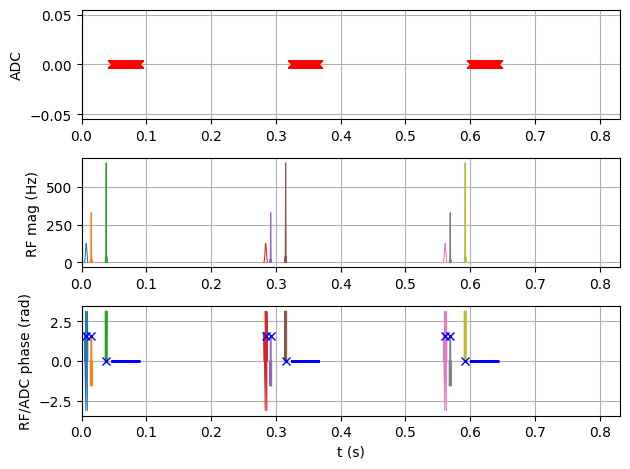

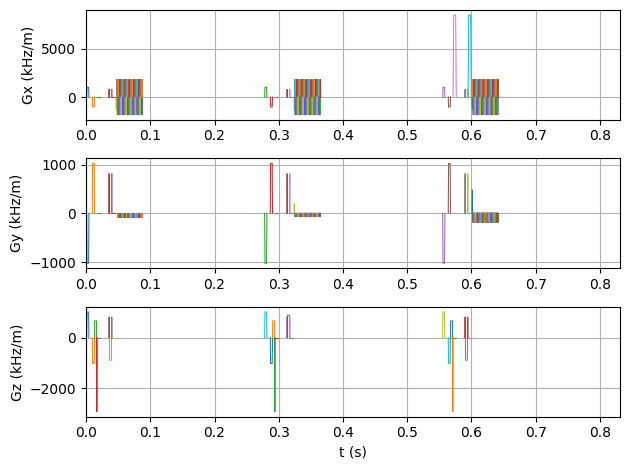

[0, 1, 0]
EPI: Echo Spacing is  0.7400000000000001 ms
EPI: ADC Bandwidth =  416.6666666666667 kHz
Actual RO oversampling factor is   1.0366530914476122
EPI: ADC Samples are  264.0
Make Fat Sat Debugging! 
Sat Frequency is -406.04731200000003
0.014961238938053095
0.014961238938053095
gyPre 1.0 gxPre -1.0


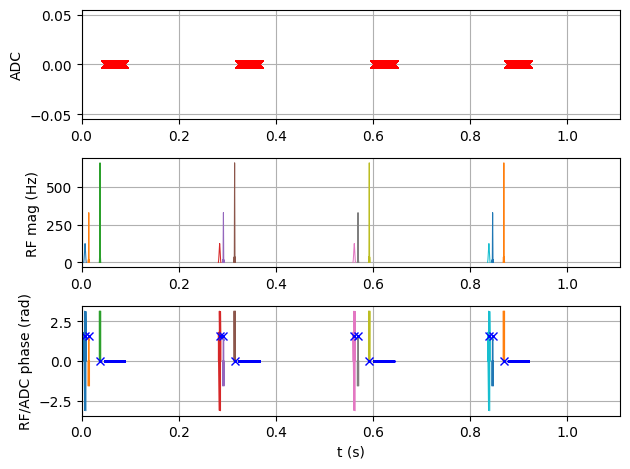

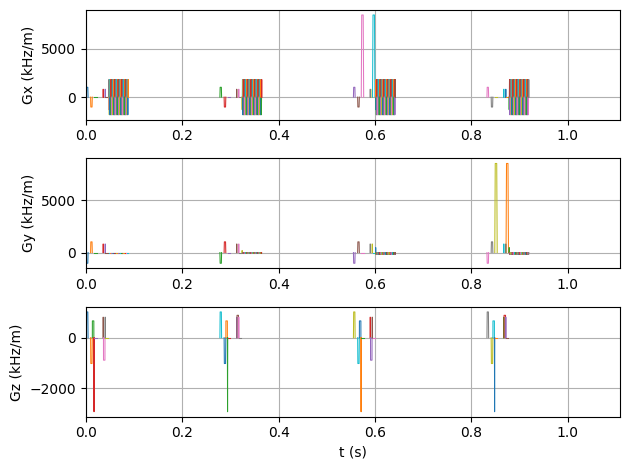

[0, 0, 1]
EPI: Echo Spacing is  0.7400000000000001 ms
EPI: ADC Bandwidth =  416.6666666666667 kHz
Actual RO oversampling factor is   1.0366530914476122
EPI: ADC Samples are  264.0
Make Fat Sat Debugging! 
Sat Frequency is -406.04731200000003
0.014961238938053095
0.014961238938053095
gyPre 1.0 gxPre -1.0


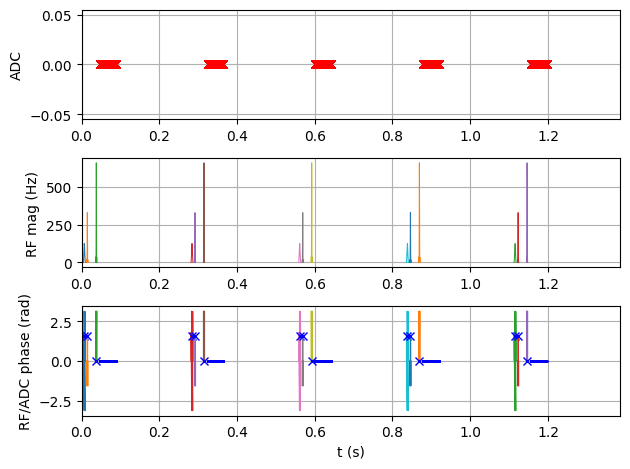

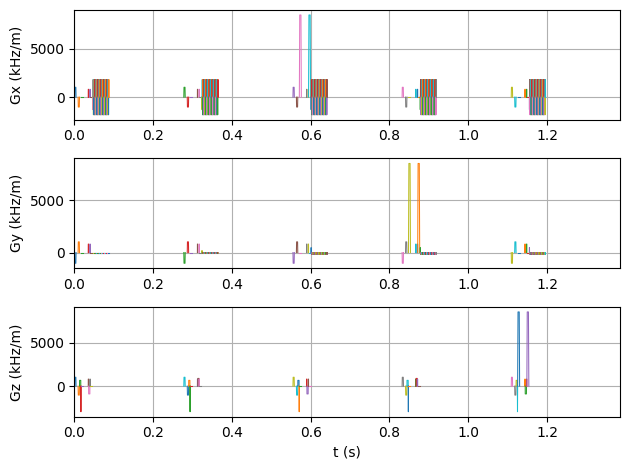

Timing check passed successfully
(3, 96250)


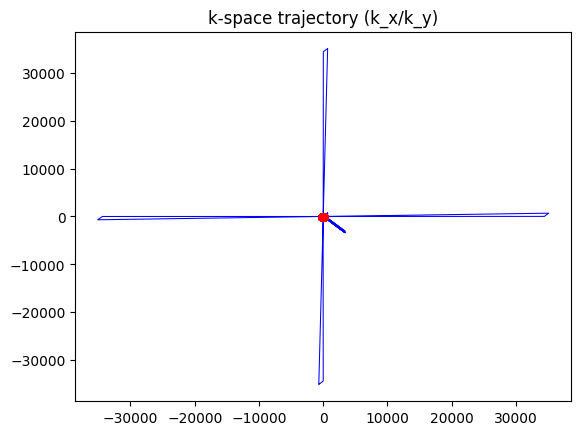

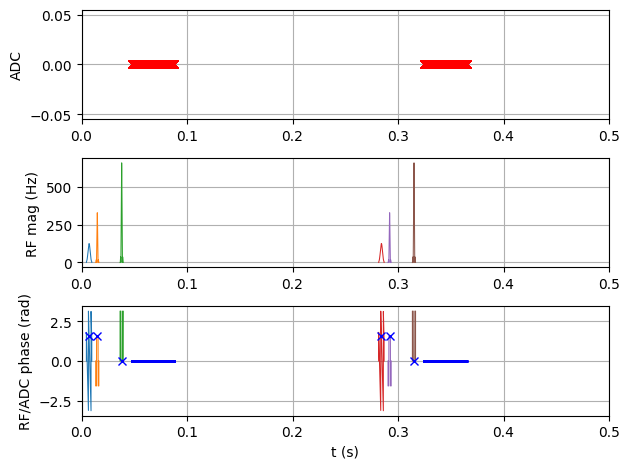

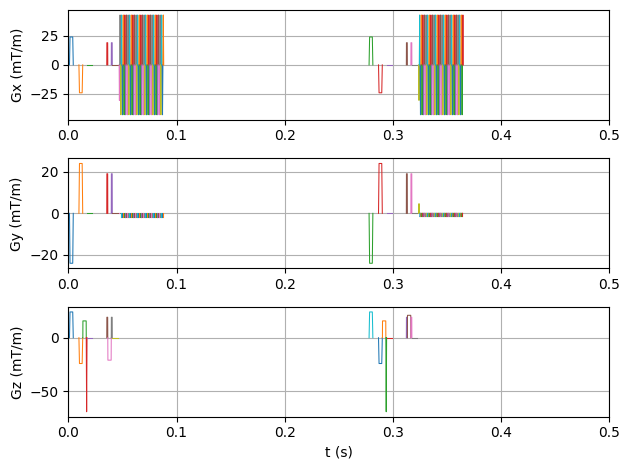

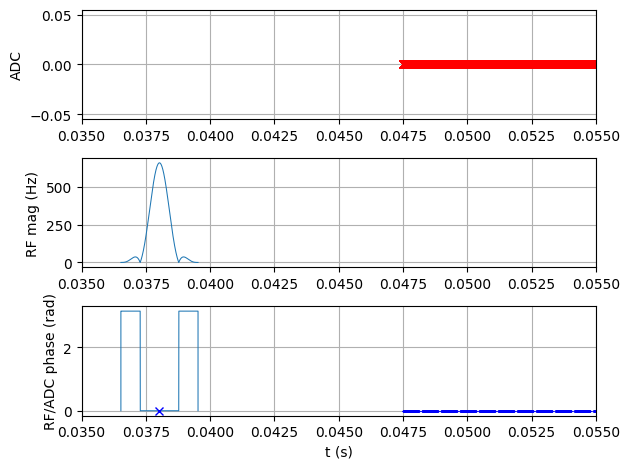

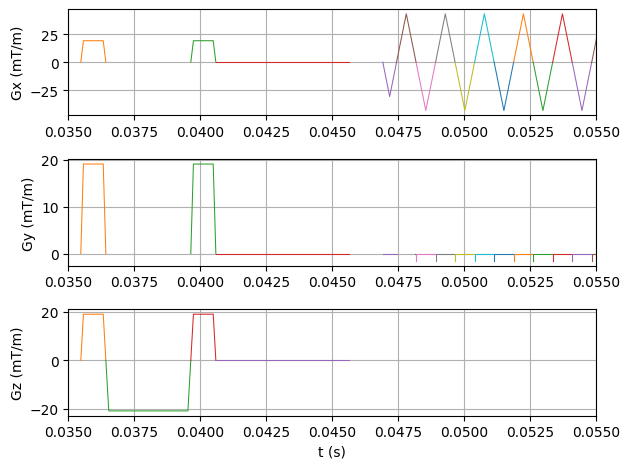

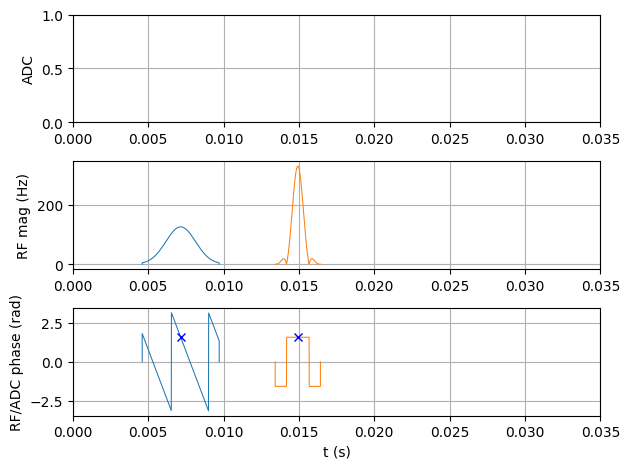

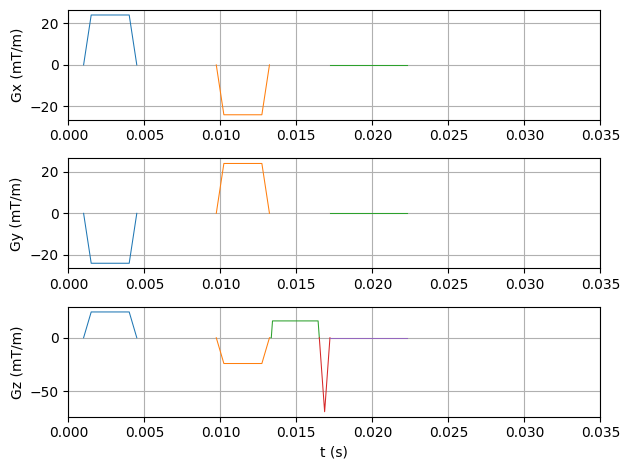

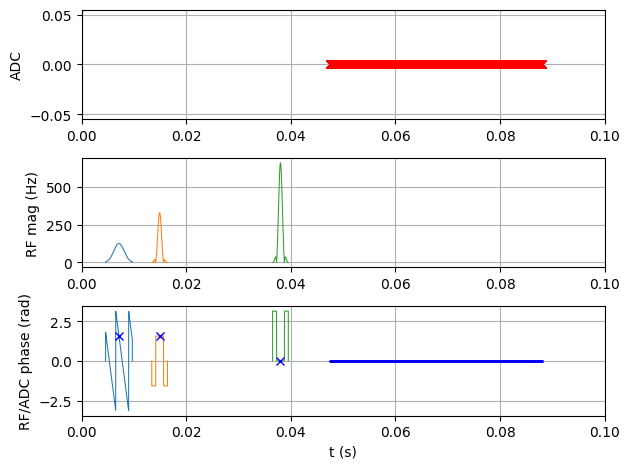

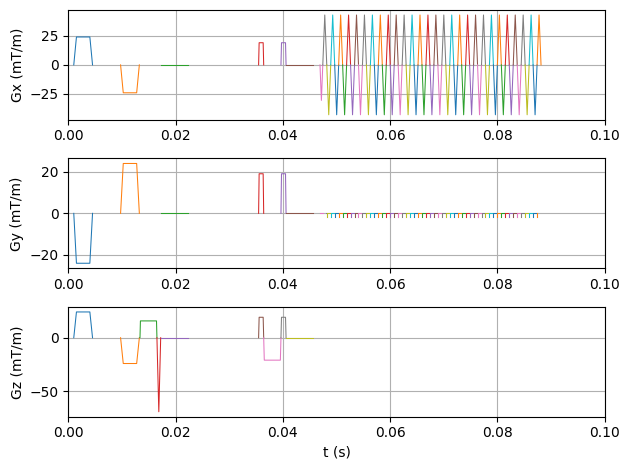

In [16]:
# Iterate Over Diffusion Vectors 
for aa in range(averages):
    count = 0

    for dd in all_diff_vec:
        # Iterate over slices 
        #pseq0.seq.add_block(pp.make_label(type= 'SET', label='SLC', value=0) )
        for s in range(Nslices):
            # Set up the Diffusi/on Vector
            #pseq_diff.prep_trap(diff_vec = dd)
            print(dd)
            #pseq_diff.prep_GrOpt(diff_vec = dd)

            # Set up the EPI readout
            for Nmulti in range(1,Rsegment+1):
                if seq_type == 'Skope' and fat_sat_type is not None:
                    pseq_fatsat.rf_fs.signal *= 0
                    pseq_90.rf.signal *= 0
                    pseq_180.rf.signal *= 0
                
                # PE Enable is off for first one for ghost scan
                if count == 0 and R > 1:
                    pe_enable = True
                elif count == 0 and R == 1:
                    pe_enable = False
                else:
                    pe_enable = True

                # EPI Prep needs to b/e done slice by slice and if two shots 
                pseq_epi = pSeq_EPI_base(pseq0, fov = real_fov,
                                nx = nx,
                                ny = ny,
                                readoutTime = readoutTime,
                                Rsegment = Rsegment,
                                partFourierFactor = pf,
                                R=R,
                                Nmulti=Nmulti,
                                ghost_lines = 3)
    
                pseq_epi.prep(ro_os = ro_os,pe_enable = pe_enable)
            
                """
                if slice_profile and not inner_volume:
                    pseq_epi.gyPre.channel = 'z'
                    pseq_epi.gy_blipdown.channel = 'z'
                    pseq_epi.gy_blipdownup.channel = 'z'
                    pseq_epi.gy_blipup.channel = 'z'
                    pseq_epi.gy_pre_post.channel = 'z'

                if flip_gy:
                    pseq_epi.gyPre= pp.scale_grad(pseq_epi.gyPre,-1)
                    pseq_epi.gy_blipdown = pp.scale_grad(pseq_epi.gy_blipdown,-1)
                    pseq_epi.gy_blipdownup= pp.scale_grad(pseq_epi.gy_blipdownup,-1)
                    pseq_epi.gy_blipup= pp.scale_grad(pseq_epi.gy_blipup,-1)
                    pseq_epi.gy_pre_post= pp.scale_grad(pseq_epi.gy_pre_post,-1)

                """

                #pseq_diff.prep_GrOpt(diff_vec = dd)
                #[pseq_epi.gxPre,pseq_epi.gyPre,pseq_90.gzReph]=pp.align(right = pseq_epi.gxPre,left =[pseq_epi.gyPre,pseq_90.gzReph])
                #pseq_epi.gyPre = pp.make_trapezoid(channel = 'y', system = pseq_epi.epi_system, 
                #                        area = pseq_epi.gyPre.area, ?
                #                        duration = pp.calc_duration(pseq_epi.gxPre,pseq_epi.gyPre,pseq_90.gzReph))
                #pseq_epi.gyPre.amplitude *= 1
                # Diffusion Prep for a given vector 
                
                # Create Sequence 

                # Noise Scan
                #lblResetRefScan = pp.make_label(type = 'SET',label = 'REF', value = False)
                #lblResetRefAndImaScan = pp.make_label(type= 'SET',label = 'IMA', value = False) 
                #pseq0.seq.add_block(pseq_epi.adc, pp.make_label(type = 'SET',label = 'LIN',value= 0),
                #                    pp.make_label(type='SET',label = 'NOISE',value = True), lblResetRefAndImaScan,lblResetRefAndImaScan)

                # Add Trig
                if ecg:
                    pseq0.add_ecgTrig(duration = 1e-3)


                if fatSat_band:
                        pseq0.seq.add_block(pp.make_delay(2e-5))
                        pseq0.add_pseq_to_self(pseq_fatSat_B1)
                        pseq0.seq.add_block(pp.make_delay(2e-5))
                        pseq0.add_pseq_to_self(pseq_fatSat_B2)
                        pseq0.seq.add_block(pp.make_delay(2e-5))

                # Add FatSat 
                if seq_type != 'Skope' and fat_sat_type is not None:
                    pseq_fatsat.prep_fatsat(verbose = True, freq_offset = freqOffset_factor[s])
                    pseq0.add_pseq_to_self(pseq_fatsat,delay = fsdelay, offset = freqOffset_factor[s])

                

                        
                # Add Excitation
                pseq_90.offset_rf(offset= freqOffset_factor[s])
                pseq0.add_pseq_to_self(pseq_90)

                # Add Diffusion or Delay TE1
                if not diff_mode:
                    pseq0.seq.add_block(pp.make_delay(pseq_diff.min_delayTE1))
                elif diff_mode == 'Trap':
                    pseq_diff.prep_trap(diff_vec = dd)
                    pseq_diff.add_to_seq(pseq0,flag = 'diff1',diff_mode = diff_mode)
                elif diff_mode == 'GrOpt':
                        pseq_diff.prep_GrOpt(diff_vec = dd)
                        pseq_diff.add_to_seq(pseq0,flag = 'diff1',diff_mode = diff_mode)
                        
                #pseq0.add_pseq_to_self(pseq_diff,flag = "diff1")
                pseq0.seq.add_block(pseq_diff.gz180_crusher_1, pseq_diff.gz180_crusher_2,pseq_diff.gz180_crusher_3)


                # Add Refocusing 
                pseq_180.offset_rf(offset= freqOffset_factor[s])
                if ssgr_mode:
                    pseq_180.gz = pp.scale_grad(pseq_180.gz,-1)
                    pseq_180.rf.freq_offset *= -1 
                    pseq_180.phase_offset = - 2*np.pi * pseq_180.rf.freq_offset * pp.calc_rf_center(pseq_180.rf)[0]
                
                    #self.phase_offset = - 2*np.pi * self.rf.freq_offset * pp.calc_rf_center(self.rf)[0]
                
                
                if inner_volume:
                    pseq_180.gz.channel = 'y'

                if reduced_fov:
                        pseq_180.gz = gz180n

                pseq0.add_pseq_to_self(pseq_180)


                #rf180_phase_offset.append(pseq_180.rf.phase_offset)
                #rf180_freq_offset.append(pseq_180.rf.freq_offset)


                # Add Diffusion or Delay + Bipolar 
                #pseq0.add_pseq_to_self(pseq_diff,flag = "diff2")
                
                pseq0.seq.add_block(pseq_diff.gz180_crusher_1, pseq_diff.gz180_crusher_2,pseq_diff.gz180_crusher_3)
                #pseq0.add_pseq_to_self(pseq_diff,flag = "diff2")

                if not diff_mode:
                    pseq0.seq.add_block(pp.make_delay(pseq_diff.min_delayTE2))
                elif diff_mode == 'Trap':
                    pseq_diff.prep_trap(diff_vec = dd)
                    pseq_diff.add_to_seq(pseq0,flag = 'diff2',diff_mode = diff_mode)
                elif diff_mode == 'GrOpt':
                        pseq_diff.prep_GrOpt(diff_vec = dd)
                        pseq_diff.add_to_seq(pseq0,flag = 'diff2',diff_mode = diff_mode)
                
                
                # Add EPI 
                pseq_epi.ghost_flag = False
                pseq0.add_pseq_to_self(pseq_epi, EchoTimeShift=EchoTimeShift,)

                #pseq0.seq.add_block(pp.make_label(type = 'INC',label = 'SLC', value = 1))
                
                # TR Calculation
                fatsat_dur = pp.calc_duration(pseq_fatsat.gx_crush_pre,pseq_fatsat.gy_crush_pre,pseq_fatsat.gz_crush_pre) \
                    + pp.calc_duration(pseq_fatsat.rf_fs) + pp.calc_duration(pseq_fatsat.gx_crush_post,pseq_fatsat.gy_crush_post,pseq_fatsat.gz_crush_post)
                # Subtract timing of fat saturation, 90, TE/2, 180, delay, epi readout 
                TR = 260e-3 - fatsat_dur - pseq_diff.timings['T_90']*1e-3 - pseq_diff.delayTE1 - \
                    pseq_diff.timings['T_180']*1e-3 - pseq_diff.delayTE2 - \
                        2*pseq_diff.timings['durationToCenter']*1e-3 + pseq_diff.timings['pre_duration']*1e-3
                
                pseq0.add_TR(TR=TR)


                iter=1
                pseq0.seq.plot()
        #print(pe_enable, pseq_epi.gyPre.amplitude, pseq_epi.gy_pre_post)
        count += 1

        # After the first diffusion sequence, writeout the sequence so that can seperately acquire blip down
        if aa == 0 and dd == [0,0,0]:
            pseq0.write_seq(seq_name =seq_file_name + '_calibBlipDown',fov = real_fov,slicePositions =freqOffset_factor, thickness = thickness, sliceGap = slice_gap,
                ro_os = pseq_epi.adc_samples/nx, Nx=nx,Ny = ny, gx = pseq_epi.gx, adc= pseq_epi.adc )
            

pseq0.write_seq(seq_name =seq_file_name,fov = real_fov,slicePositions =freqOffset_factor, thickness = thickness, sliceGap = slice_gap,
            ro_os = pseq_epi.adc_samples/nx, Nx=nx,Ny = ny, gx = pseq_epi.gx, adc= pseq_epi.adc )
pseq0.get_report()       
[k_traj_adc, k_traj,t_excitation, t_refocusing, t_adc]  = pseq0.seq.calculate_kspace()



# Plot K-space trajectory 
print(k_traj.shape)
plt.plot(k_traj[0,:], k_traj[1,:],'b')
plt.plot(k_traj_adc[0,:], k_traj_adc[1,:],'r.')
plt.title('k-space trajectory (k_x/k_y)')
plt.show()     

# Plot different time points 
pseq0.seq.plot(time_range = [0.0, 0.5],grad_disp='mT/m')
pseq0.seq.plot(time_range = [0.035, 0.055],grad_disp='mT/m')
pseq0.seq.plot(time_range = [0.0, 0.035],grad_disp='mT/m')

pseq0.seq.plot(time_range = [0.0, 0.1],grad_disp='mT/m')


In [17]:
pseq_diff.delayTE2

np.float64(0.0063300000000000006)

In [18]:
pseq_diff.timings

{'T_90': np.float64(2.28),
 'T_180': 5.119999999999999,
 'dt': 1e-05,
 'T_readout': np.float64(14.210000000000003),
 'durationToCenter': np.float64(13.690000000000003),
 'pre_duration': 0.52,
 'b': 1000,
 'MMT': 0,
 'pns_thresh': 10,
 'gmax': 199,
 'smax': 186,
 'tol': 0.01,
 'mode': 'diff_bval',
 'TE': np.float64(44.28000000000002)}

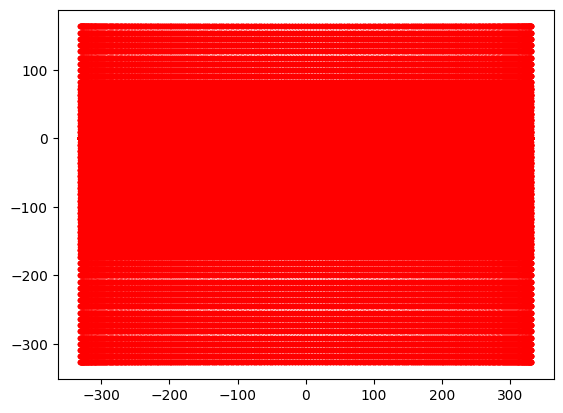

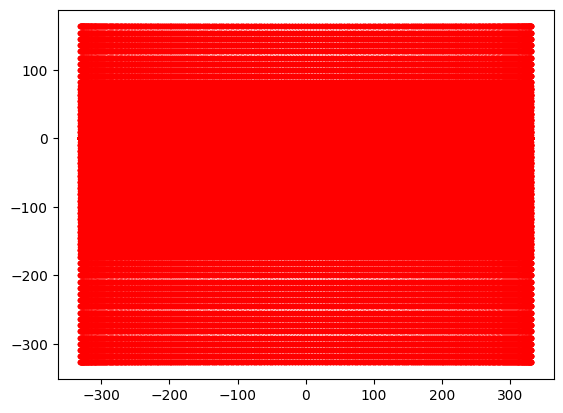

In [19]:
[k_traj_adc, k_traj,t_excitation, t_refocusing, t_adc]  = pseq0.seq.calculate_kspace()
plt.plot(k_traj_adc[0,:], k_traj_adc[1,:],'r.')
plt.show()

seq2= seq = pp.Sequence()
seq2.read(os.path.join(seq_file_name + '.seq'),detect_rf_use=True)

[k_traj_adc, k_traj,t_excitation, t_refocusing, t_adc]  = seq2.calculate_kspace()
plt.plot(k_traj_adc[0,:], k_traj_adc[1,:],'r.')

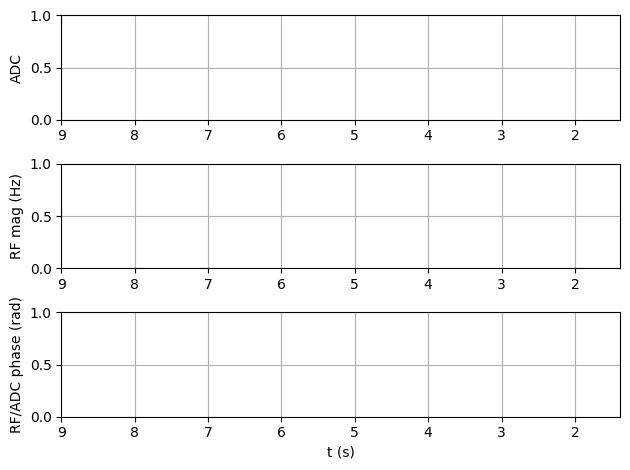

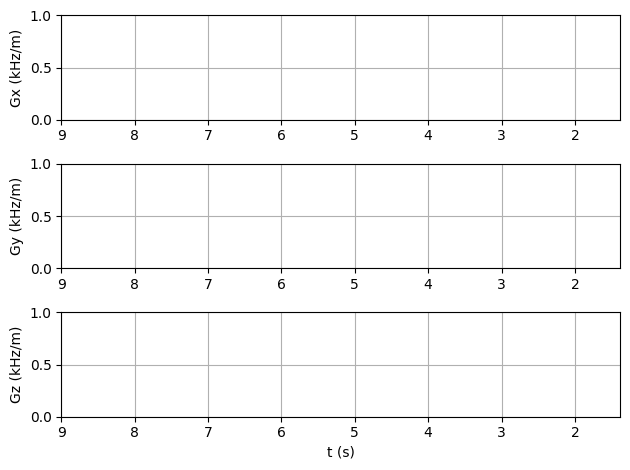

In [20]:
pseq0.seq.plot(time_range = [9,9.25])

(3, 96260)


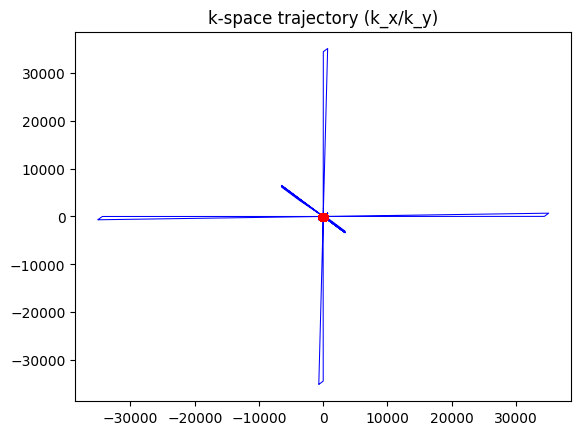

In [21]:
print(k_traj.shape)
plt.plot(k_traj[0,:], k_traj[1,:],'b')
plt.plot(k_traj_adc[0,:], k_traj_adc[1,:],'r.')
#plt.xlim(min(k_traj_adc[0,:]-10),max(k_traj_adc[0,:])+10)
#plt.ylim(min(k_traj_adc[1,:]-10),max(k_traj_adc[1,:])+10)
plt.title('k-space trajectory (k_x/k_y)')
plt.show()  

PNS is OK
CNS is NOT OK


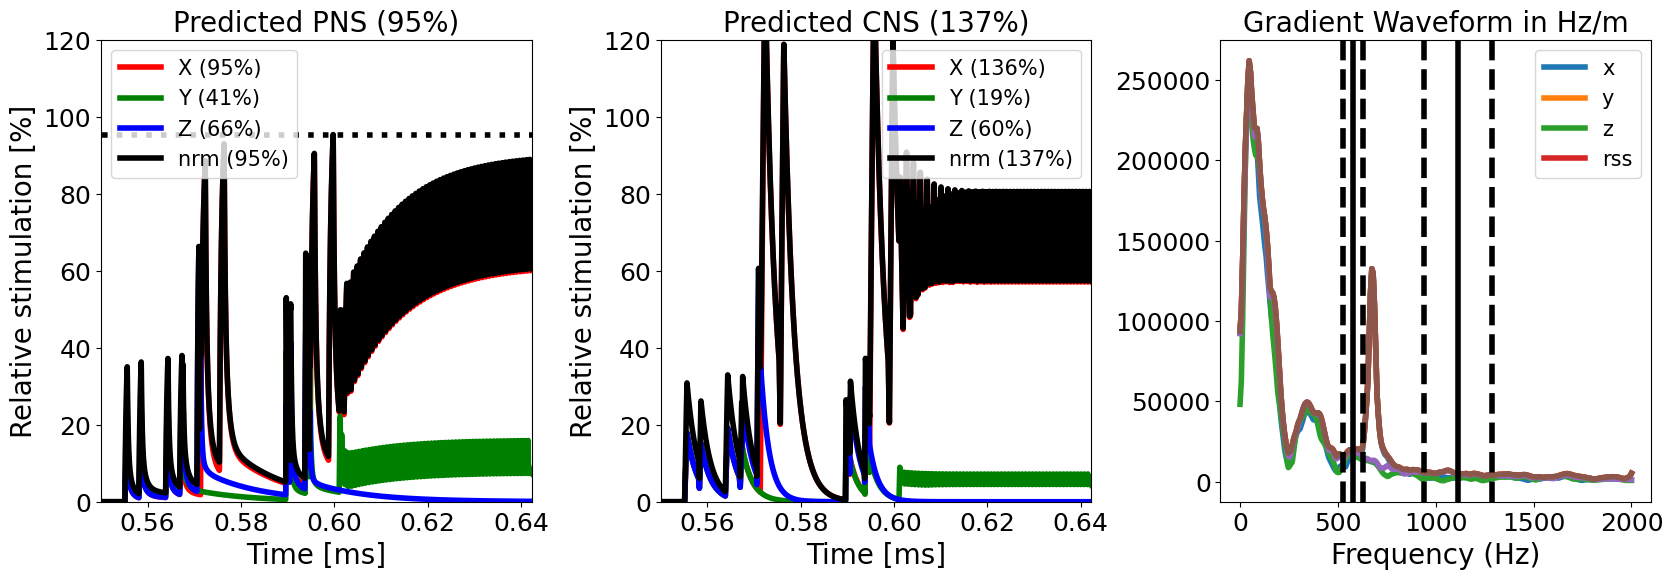

In [22]:
pseq0.check_safety_lims(cns= True,time_range = [0.55,0.7])

In [23]:
os.path.join('/Users/ariel/Desktop/To_Mike_240821/IV_Error_Script',seq_file_name + '.seq')

'/Users/ariel/Desktop/To_Mike_240821/IV_Error_Script/fig_cima_workshop146x146_R2_pf0.75ssgr__sinc_R2_NSl1Avg1_PF0.75__FOV220_Trap_mmt0_b1000.seq'

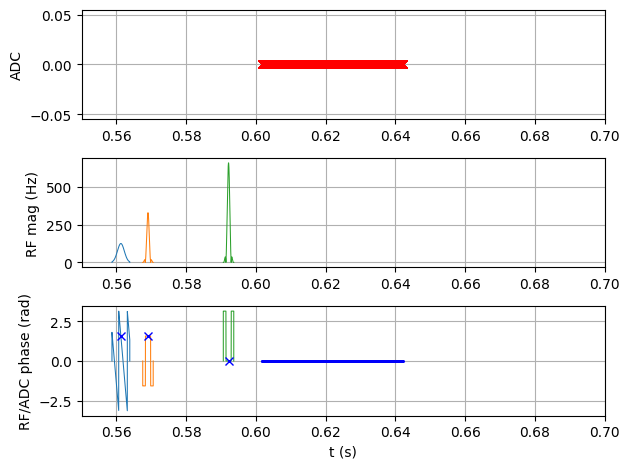

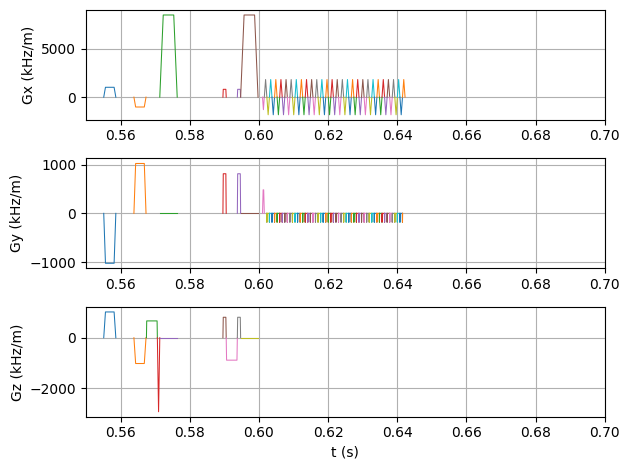

In [24]:
import matplotlib.pyplot as plt
plt.rcdefaults()

pseq0.seq.plot(time_range=[0.55,0.7])